In [5]:
def read_obj_file(file_path):
    # Üres lista a csúcsok (vertexek) tárolására
    vertices = []
    
    # Megnyitjuk az .obj fájlt olvasásra
    with open(file_path, 'r') as file:
        # Bejárjuk a fájl minden sorát
        for line in file:
            # Ellenőrizzük, hogy a sor csúcsot (vertex) tartalmaz-e
            if line.startswith('v '):  # Az .obj fájlban a csúcsok 'v' karakterrel kezdődnek
                # A sort szóközök mentén feldaraboljuk egy listába
                parts = line.split()
                # A csúcs koordinátáit hozzáadjuk a vertices listához
                # parts[1], parts[2], parts[3] az x, y, z koordináták (mivel parts[0] a 'v' karakter)
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
    
    # Visszaadjuk a csúcsok listáját
    return vertices

# Példa használat
file_path = 'boat_reconst_simple.obj'  # Az .obj fájl elérési útja
vertices = read_obj_file(file_path)  # A csúcsok kinyerése a fájlból

# Kiírjuk a csúcsok számát
print(f"Összesen {len(vertices)} csúcs található.")

# Kiírjuk az első 3 csúcsot
print(f"Az első 3 csúcs: {vertices[:3]}")

Összesen 12890 csúcs található.
Az első 3 csúcs: [[59.2268, 282.49, 376.038], [58.9599, 284.275, 376.69], [58.8884, 284.639, 377.036]]


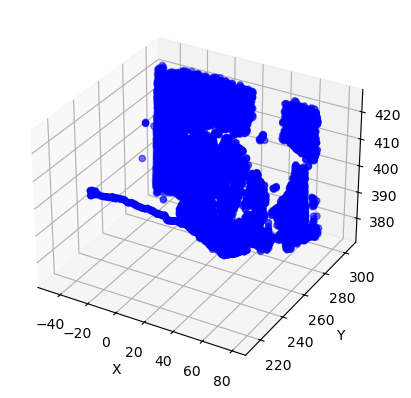

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(vertices):
    # Létrehozunk egy új ábrát (figure) és egy 3D-s tengelyt (axis)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')  # 111: 1x1-es rács, 1. rész
    
    # Kinyerjük a csúcsok x, y, z koordinátáit
    xs = [v[0] for v in vertices]  # Az összes csúcs x koordinátája
    ys = [v[1] for v in vertices]  # Az összes csúcs y koordinátája
    zs = [v[2] for v in vertices]  # Az összes csúcs z koordinátája
    
    # Megjelenítjük a pontfelhőt a 3D-s tengelyen
    ax.scatter(xs, ys, zs, c='b', marker='o')  # 'b' = kék szín, 'o' = kör alakú pontok
    
    # Tengelyfeliratok beállítása
    ax.set_xlabel('X')  # X tengely felirata
    ax.set_ylabel('Y')  # Y tengely felirata
    ax.set_zlabel('Z')  # Z tengely felirata
    
    # Megjelenítjük az ábrát
    plt.show()

# Pontfelhő megjelenítése
plot_point_cloud(vertices)

In [7]:
import numpy as np

def calculate_distances(vertices):
    # Számítsd ki a pontok távolságát az origótól (vagy a kamera középpontjától)
    distances = np.linalg.norm(vertices, axis=1)
    return distances

def normalize_distances(distances):
    # Normalizáljuk a távolságokat 0 és 1 közé
    return (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

def assign_colors(distances):
    # Színek hozzárendelése: közelebbi pontok sötétebbek, távolabbiak világosabbak
    colors = 1 - distances  # Invertáljuk, hogy a közelebbi pontok sötétebbek legyenek
    return colors

# Példa használat
distances = calculate_distances(vertices)
normalized_distances = normalize_distances(distances)
colors = assign_colors(normalized_distances)

In [8]:
import open3d as o3d

def create_point_cloud(vertices, colors):
    point_cloud = o3d.geometry.PointCloud() #üres pontfelhő létrehozása
    point_cloud.points = o3d.utility.Vector3dVector(vertices) #csúcsok hozzáadása
    point_cloud.colors = o3d.utility.Vector3dVector(np.vstack([colors, colors, colors]).T) #színek hozzáadása
    return point_cloud #visszatérés a pontfelhővel

# Pontfelhő létrehozása
point_cloud = create_point_cloud(vertices, colors)

# Megjelenítés
o3d.visualization.draw_geometries([point_cloud])

In [9]:
import open3d as o3d
import numpy as np

# Pontfelhő létrehozása
point_cloud = point_cloud.voxel_down_sample(voxel_size=0.1)
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(vertices)

# Normálvektorok számítása (szükséges a BPA-hez)
point_cloud.estimate_normals()

# Ball Pivoting Algorithm
distances = point_cloud.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist  # A golyó sugara

mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    point_cloud,
    o3d.utility.DoubleVector([radius, radius * 2, radius * 3, radius * 10])
)

# Megjelenítés
o3d.visualization.draw_geometries([mesh])

In [10]:
import open3d as o3d
import numpy as np

def create_point_cloud(vertices, colors):
    point_cloud = o3d.geometry.PointCloud()  # Üres pontfelhő létrehozása
    point_cloud.points = o3d.utility.Vector3dVector(vertices)  # Csúcsok hozzáadása
    point_cloud.colors = o3d.utility.Vector3dVector(colors)  # Színek hozzáadása
    return point_cloud  # Visszatérés a pontfelhővel

def calculate_distances(vertices):
    # Számítsd ki a pontok távolságát az origótól (vagy a kamera középpontjától)
    distances = np.linalg.norm(vertices, axis=1)
    return distances

def normalize_distances(distances):
    # Normalizáljuk a távolságokat 0 és 1 közé
    return (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

def assign_colors(distances):
    # Színek hozzárendelése: közelebbi pontok sötétebbek, távolabbiak világosabbak
    colors = np.repeat(distances[:, np.newaxis], 3, axis=1)  # Minden távolsághoz 3 azonos érték (szürkeárnyalat)
    return 1 - colors  # Invertáljuk, hogy a közelebbi pontok sötétebbek legyenek

# Példa használat
distances = calculate_distances(vertices)
normalized_distances = normalize_distances(distances)
colors = assign_colors(normalized_distances)

# Pontfelhő létrehozása
point_cloud = create_point_cloud(vertices, colors)

# Pontfelhő leminősítése (voxel down-sampling)
point_cloud = point_cloud.voxel_down_sample(voxel_size=0.05)

# Normálvektorok számítása (szükséges a BPA-hez)
point_cloud.estimate_normals()
point_cloud.orient_normals_consistent_tangent_plane(k=20)

# Ball Pivoting Algorithm
distances = point_cloud.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist  # A golyó sugara

# Sugarak beállítása
radii = [radius, radius * 1.5, radius * 2, radius * 5]  # Példa: több sugár
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    point_cloud,
    o3d.utility.DoubleVector(radii))

# Háló simítása
mesh = mesh.filter_smooth_taubin(number_of_iterations=10)
mesh.compute_vertex_normals()  # Normálvektorok újraszámítása

# Pontfelhő és háló együttes megjelenítése
o3d.visualization.draw_geometries([point_cloud, mesh])

In [ ]:
import open3d as o3d
import numpy as np

def read_obj_file(file_path):
    # Üres lista a csúcsok (vertexek) tárolására
    vertices = []
    
    # Megnyitjuk az .obj fájlt olvasásra
    with open(file_path, 'r') as file:
        # Bejárjuk a fájl minden sorát
        for line in file:
            # Ellenőrizzük, hogy a sor csúcsot (vertex) tartalmaz-e
            if line.startswith('v '):  # Az .obj fájlban a csúcsok 'v' karakterrel kezdődnek
                # A sort szóközök mentén feldaraboljuk egy listába
                parts = line.split()
                # A csúcs koordinátáit hozzáadjuk a vertices listához
                # parts[1], parts[2], parts[3] az x, y, z koordináták (mivel parts[0] a 'v' karakter)
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
    
    # Visszaadjuk a csúcsok listáját
    return vertices

# Példa használat
file_path = 'boat_reconst_simple.obj'  # Az .obj fájl elérési útja
vertices = read_obj_file(file_path)  # A csúcsok kinyerése a fájlból

def calculate_distances(vertices):
    # Számítsd ki a pontok távolságát az origótól (vagy a kamera középpontjától)
    distances = np.linalg.norm(vertices, axis=1)
    return distances

def normalize_distances(distances):
    # Normalizáljuk a távolságokat 0 és 1 közé
    return (distances - np.min(distances)) / (np.max(distances) - np.min(distances))

def assign_colors(distances):
    # Színek hozzárendelése: közelebbi pontok sötétebbek, távolabbiak világosabbak
    colors = np.repeat(distances[:, np.newaxis], 3, axis=1)  # Minden távolsághoz 3 azonos érték (szürkeárnyalat)
    return 1 - colors  # Invertáljuk, hogy a közelebbi pontok sötétebbek legyenek

# Távolságok és színek kiszámítása
distances = calculate_distances(vertices)
normalized_distances = normalize_distances(distances)
colors = assign_colors(normalized_distances)

def create_point_cloud(vertices, colors):
    point_cloud = o3d.geometry.PointCloud()  # Üres pontfelhő létrehozása
    point_cloud.points = o3d.utility.Vector3dVector(vertices)  # Csúcsok hozzáadása
    point_cloud.colors = o3d.utility.Vector3dVector(colors)  # Színek hozzáadása
    return point_cloud  # Visszatérés a pontfelhővel

# Pontfelhő létrehozása
point_cloud = create_point_cloud(vertices, colors)

# Pontfelhő leminősítése (voxel down-sampling)
point_cloud = point_cloud.voxel_down_sample(voxel_size=0.05)

# Normálvektorok számítása (szükséges a BPA-hez)
point_cloud.estimate_normals()
point_cloud.orient_normals_consistent_tangent_plane(k=20)

# Ball Pivoting Algorithm
distances = point_cloud.compute_nearest_neighbor_distance()
avg_dist = np.mean(distances)
radius = 3 * avg_dist  # A golyó sugara

# Sugarak beállítása
radii = [radius, radius * 1.5, radius * 2, radius * 5]  # Példa: több sugár
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
    point_cloud,
    o3d.utility.DoubleVector(radii))

# Háló simítása
mesh = mesh.filter_smooth_taubin(number_of_iterations=10)
mesh.compute_triangle_normals()  # Háromszög normálok újraszámítása
mesh.compute_vertex_normals()  # Csúcsnormálok újraszámítása

# Pontfelhő és háló együttes megjelenítése
o3d.visualization.draw_geometries(
    [point_cloud, mesh],
    mesh_show_back_face=True  # Hátsó oldalak megjelenítése
)